<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «-------» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

Откроем файл с данными, сразу прописав в качестве индексов первый столбец

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/Users/lesha_sm/Downloads/taxi.csv')

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Для уверенности, что все значения индексов (даты/времени) идут по порядку, отсортируем их по возрастанию

In [5]:
data.sort_index(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Тип данных целевого признака корректен, можно проводить ресемплирование.

Проведем ресемплирование данных по 1 часу, взяв среднее значение по состоянию на каждый час

In [7]:
data = data.resample('1H').sum()

## Анализ

Проанализируем получившиеся данные

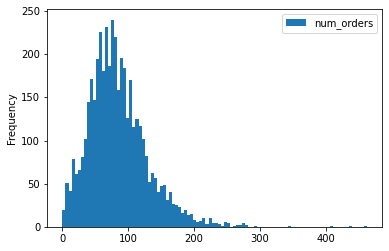

In [8]:
data.plot(kind='hist', bins=100)
plt.show()

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Распредление данных о количестве заказов имеет нормальный вид со смещением вправо. Выбросов аномальных значений не наблюдается

In [10]:
decomposed = seasonal_decompose(data)

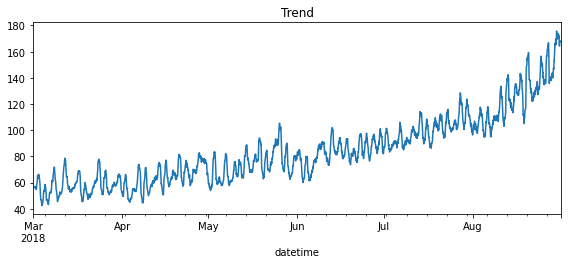

In [11]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.tight_layout()

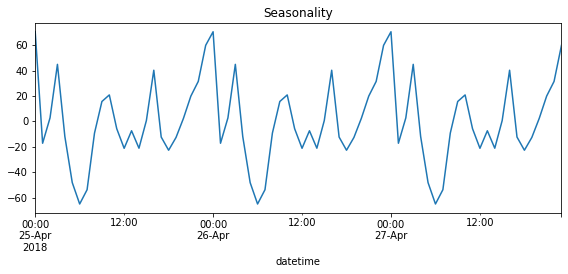

In [12]:
decomposed = seasonal_decompose(data['2018-04-25':'2018-04-27'])
plt.figure(figsize=(8, 10))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

С начала весы до конца лета наблюдается устойчивый тренд на увеличение количества заказов. Изучая график сезонности можно заключить, что количество заказов растет в начале дня и вечернее время, что может объясняться началом и концом рабочего дня.

Для корректной работы прогнозирующей модели необходимо большее количество признаков. Из имеющихся данных создадим новые дополнительные признаки трех типов: календарные признаки, отстающие значения и плавающее среднее. Для этого я напишу функцию make_features, после чего применю ее к датасету


In [13]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)


    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 4, 8)

In [14]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN


При создании отстающих значений и плавающего среднего образовались пропуски в первых строках. Удалим эти строки для дальнейшего использования данных в моделях.

In [15]:
data = data.dropna()
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,52.750
2018-03-01 09:00:00,69,9,3,34.0,15.0,12.0,6.0,41.500
2018-03-01 10:00:00,64,10,3,69.0,34.0,15.0,12.0,39.500
2018-03-01 11:00:00,96,11,3,64.0,69.0,34.0,15.0,38.625
2018-03-01 12:00:00,30,12,3,96.0,64.0,69.0,34.0,42.375


Пропуски удалены. Далее поделим датасет на обучающую и тестовую выборки. При этом "отключим" перемешивание данных при делении, чтобы хронологический порядок сохранился

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Чтобы убедиться в корректности разделения, посмотрим на минимальные и максимальные значения индексов обучающей и тестовой выборок

In [17]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 08:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


**Вывод**: разделение прошло корректно, данные можно передавать модели

## Обучение

Обучим разные модели, и оценим качество их прогноза с помощью метрики RMSE. Используем обучающий набор данных train

### LinearRegression

In [18]:
model = LinearRegression()

In [19]:
%%time
model.fit(train_features, train_target)

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 2.62 ms


LinearRegression()

In [20]:
preds_train = model.predict(train_features)

In [21]:
print("RMSE на Линейной регрессии:", round(mean_squared_error(train_target, preds_train, squared=False), 3))

RMSE на Линейной регрессии: 31.367


Время обучения - порядка 3 сек., значение метрики качества в дальнейшем сравним с другими моделями.

### DecisionTreeRegressor

Обучим модель "Дерево решений" с использованием разных гиперпараметров

In [22]:
rmse = []
for d in range (5, 16, 1):
    tree = DecisionTreeRegressor(random_state = 2007,
                                 max_depth=d,
                                 min_samples_leaf = d,
                                 min_samples_split = d
                                )
    %timeit tree.fit(train_features, train_target)
    tree_preds = tree.predict(train_features)
    rmse.append(round(mean_squared_error(train_target, tree_preds, squared=False), 3))
    
    print('max_depth=', d, "RMSE:", round(mean_squared_error(train_target, tree_preds, squared=False), 3))
    
print('')
print ('Лучшее значение RMSE:', min(rmse))

9.37 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 5 RMSE: 25.656
9.63 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 6 RMSE: 23.934
11.2 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 7 RMSE: 22.766
12.3 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 8 RMSE: 21.616
13.8 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 9 RMSE: 20.803
14 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 10 RMSE: 20.289
14.1 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 11 RMSE: 20.203
14.3 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 12 RMSE: 20.274
14.2 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 13 RMSE: 20.45
13.7 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
max_depth= 14 RMSE: 20.691
13.7 ms ± 126 µs per loop (

**Вывод:** лучшее значение метрики RMSE получено при max_depth= 11. Время обучения - порядка 15мс. Оптимально использовать его в работе данной модели

### RandomForestRegressor

Для обучения Случайного леса возьмем два разных варианта гиперпараметров и сравним полученные значения метрики.

In [23]:
rf_reg = RandomForestRegressor(random_state=2007, 
                                max_depth=10,
                               min_samples_leaf = 5,
                               min_samples_split = 6)

In [24]:
%%time
rf_reg.fit(train_features, train_target)

CPU times: user 955 ms, sys: 3.96 ms, total: 959 ms
Wall time: 965 ms


RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=6,
                      random_state=2007)

In [25]:
preds_rf = rf_reg.predict(train_features)

In [26]:
print("RMSE на Случайном лесе1:", round(mean_squared_error(train_target, preds_rf, squared=False),3))

RMSE на Случайном лесе1: 18.169


Изменим параметры модели и проследим за возможным изменением времени обучения/предсказания и - изменением метрики

In [27]:
rf_reg = RandomForestRegressor(random_state=2007, 
                                max_depth=5,
                               min_samples_leaf = 2,
                               min_samples_split = 4)

In [28]:
%%time
rf_reg.fit(train_features, train_target)

CPU times: user 544 ms, sys: 0 ns, total: 544 ms
Wall time: 545 ms


RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4,
                      random_state=2007)

In [29]:
preds_rf = rf_reg.predict(train_features)

In [30]:
print("RMSE на Случайном лесе2:", round(mean_squared_error(train_target, preds_rf, squared=False),3))

RMSE на Случайном лесе2: 24.52


Первый вариант гиперпараметров Случайного леса - оптимальней, так как значение метрики гораздо ниже, хотя модель 
и обучается дольше.

**Вывод:**
<br>Данных немного, поэтому все модели обучаются довольно быстро. Дольше всех обучается ансамбль Случайного леса, однако обеспечивает лучшее качество прогноза. Для тестирования возьмем именно эту модель.

## Тестирование

Проверим работу модели на тестовых данных. Для этого заново обучим модель на гиперпараметрах с лучшими показателями метрик и предскажем значения целевого признака на тестовых данных

In [31]:
rf_reg = RandomForestRegressor(random_state=2007,
                               max_depth=15,
                               min_samples_leaf = 4,
                               min_samples_split = 6
                              )

In [32]:
%%time
rf_reg.fit(train_features, train_target)

CPU times: user 1.04 s, sys: 3.98 ms, total: 1.04 s
Wall time: 1.04 s


RandomForestRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=6,
                      random_state=2007)

In [33]:
preds_test = rf_reg.predict(test_features)

In [34]:
print("RMSE тестовой выборки:", round(mean_squared_error(test_target, preds_test, squared=False),3))

RMSE тестовой выборки: 47.112


Визуально интерпретируем предсказания относительно целевых значений за период в несколько дней. Для этого построим сдвоенный график первых 200 записей предсказаний и целевого признака тестовой выборки.

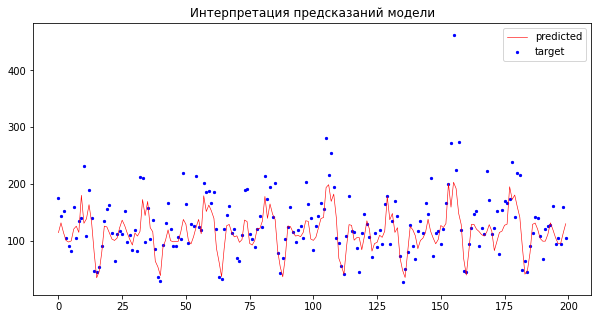

In [35]:
x_ax = range(len(test_features[0:200]))
plt.figure(figsize=(10, 5))
plt.scatter(x_ax, test_target[0:200], s=5, color="blue", label="target")
plt.plot(x_ax, preds_test[0:200], lw=0.6, color="red", label="predicted")
plt.legend()
plt.title('Интерпретация предсказаний модели')
plt.show()

Из сдвоенного графика видно, что с предсказанием большей части значений модель справляется хорошо.

## Вывод


Проведен анализ исторических данных по количеству заказов такси в период с марта 2018 по август 2018. Данные ресемплированы до более интерпретируемого для нашей задачи вида, добавлены признаки.
<br> 
<br>Далее данные были разделены на выборки, с помощью которых проверена работа нескольких моделей, а по результатам выбрана лучшая по значению метрики RMSE.
<br> 
<br>Работа подобранной модели была протестирована на тестовом наборе данных, в результате чего целевое значение метрики не было превышено (получено значение = 47.112), время обучения = 1 сек - приемлемо. Визуальная интерпретация предсказаний выбранной модели также позволяет судить о том, что модель работает корректно и правильно предсказывает большинство значений. 
<br> 
<br>Можно сделать вывод о том, что выбранная модель оптимально подходит для прогнозирования количества заказов такси.  